In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [4]:
import os

# Specify the folder path (replace with your desired path)
folder_path = "/kaggle/input/lfwpeople"  # Example for Windows
# folder_path = "/home/yourusername/documents"  # Example for Linux/Mac

# Check if the folder exists
if os.path.exists(folder_path):
    print("Exploring Directory:", folder_path)
    for item in os.listdir(folder_path):
        print(item)
else:
    print("Folder does not exist.")

Exploring Directory: /kaggle/input/lfwpeople
pairsDevTrain.txt
lfw-funneled.tgz
pairsDevTest.txt
pairs.txt


In [6]:
# Install necessary libraries (if not already installed)
!pip install opencv-python matplotlib

# Import libraries
import tarfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Define the dataset path (based on the screenshot)
dataset_path = "/kaggle/input/lfwpeople"
tgz_file = os.path.join(dataset_path, "lfw-funneled.tgz")
extracted_dir = "/kaggle/working/lfw-funneled"

# Create a directory to extract the files
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Extract the .tgz file
print("Extracting the dataset...")
with tarfile.open(tgz_file, "r:gz") as tar:
    tar.extractall(path=extracted_dir)

print("Extraction complete!")

Extracting the dataset...
Extraction complete!


Total number of people in the dataset: 5749
Sample directories: ['Russ_Ortiz', 'Gabi_Zimmer', 'Alberto_Acosta', 'Judy_Dean', 'William_Bulger']


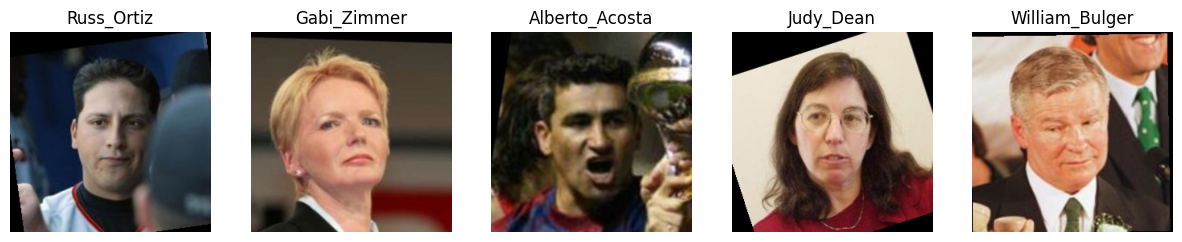

In [7]:
# List the directories (each directory corresponds to a person)
lfw_images_dir = os.path.join(extracted_dir, "lfw_funneled")
people_dirs = [d for d in os.listdir(lfw_images_dir) if os.path.isdir(os.path.join(lfw_images_dir, d))]
print(f"Total number of people in the dataset: {len(people_dirs)}")
print("Sample directories:", people_dirs[:5])

# Load and display a few sample images
sample_images = []
sample_labels = []

# Pick the first few people and one image from each
for person in people_dirs[:5]:  # Limit to 5 people for visualization
    person_dir = os.path.join(lfw_images_dir, person)
    images = [f for f in os.listdir(person_dir) if f.endswith(".jpg")]
    if images:
        img_path = os.path.join(person_dir, images[0])  # Take the first image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
        sample_images.append(img)
        sample_labels.append(person)

# Display the sample images
plt.figure(figsize=(15, 5))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

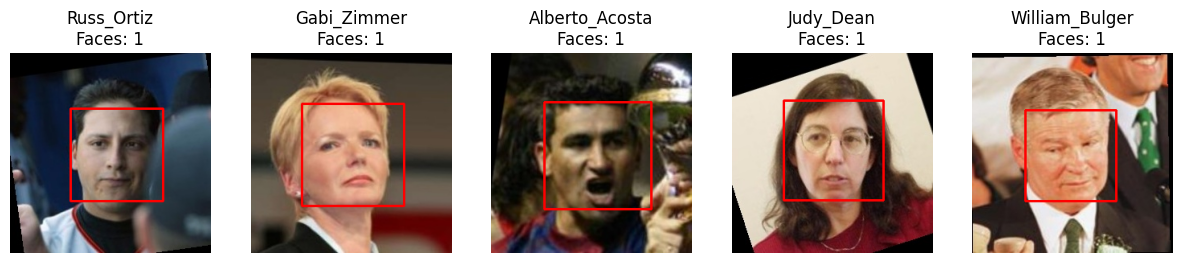

In [8]:
# Load OpenCV's pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Detect and display faces in the sample images
plt.figure(figsize=(15, 5))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    faces = detect_faces(img)
    img_copy = img.copy()
    
    # Draw rectangles around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img_copy)
    plt.title(f"{label}\nFaces: {len(faces)}")
    plt.axis("off")
plt.show()

In [9]:
# Confirm if detected faces are human (for LFW, they are all human)
for i, (img, label, faces) in enumerate(zip(sample_images, sample_labels, [detect_faces(img) for img in sample_images])):
    if len(faces) > 0:
        print(f"Image {i+1} ({label}): Face detected - Likely a human (LFW dataset contains real human faces).")
    else:
        print(f"Image {i+1} ({label}): No face detected.")

Image 1 (Russ_Ortiz): Face detected - Likely a human (LFW dataset contains real human faces).
Image 2 (Gabi_Zimmer): Face detected - Likely a human (LFW dataset contains real human faces).
Image 3 (Alberto_Acosta): Face detected - Likely a human (LFW dataset contains real human faces).
Image 4 (Judy_Dean): Face detected - Likely a human (LFW dataset contains real human faces).
Image 5 (William_Bulger): Face detected - Likely a human (LFW dataset contains real human faces).


In [10]:
# Load the pairs.txt file
pairs_file = os.path.join(dataset_path, "pairs.txt")
with open(pairs_file, "r") as f:
    pairs_data = f.readlines()

# Display the first few lines
print("Sample lines from pairs.txt:")
for line in pairs_data[:5]:
    print(line.strip())

Sample lines from pairs.txt:
10	300
Abel_Pacheco	1	4
Akhmed_Zakayev	1	3
Akhmed_Zakayev	2	3
Amber_Tamblyn	1	2


In [11]:
# Install deepface (if not already installed)
!pip install deepface

# Import libraries (including those from the previous code)
import tarfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from deepface import DeepFace

# Define the dataset path (based on the screenshot)
dataset_path = "/kaggle/input/1fwpeople"
tgz_file = os.path.join(dataset_path, "lfw-funneled.tgz")
extracted_dir = "/kaggle/working/lfw-funneled"

# Create a directory to extract the files (if not already done)
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Extract the .tgz file (if not already extracted)
if not os.path.exists(os.path.join(extracted_dir, "lfw_funneled")):
    print("Extracting the dataset...")
    with tarfile.open(tgz_file, "r:gz") as tar:
        tar.extractall(path=extracted_dir)
    print("Extraction complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=316f987faffaccbdcc6c5fd6aa38a382437368fe2862fb0767ab69ca930bae21
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
25-03-22 15:42:59 - Directory /root/.deepface has been created
25-03-22 15:42:59 - Directory /root/.deepface/weights has been created


Total number of people in the dataset: 5749
Sample directories: ['Russ_Ortiz', 'Gabi_Zimmer', 'Alberto_Acosta', 'Judy_Dean', 'William_Bulger']


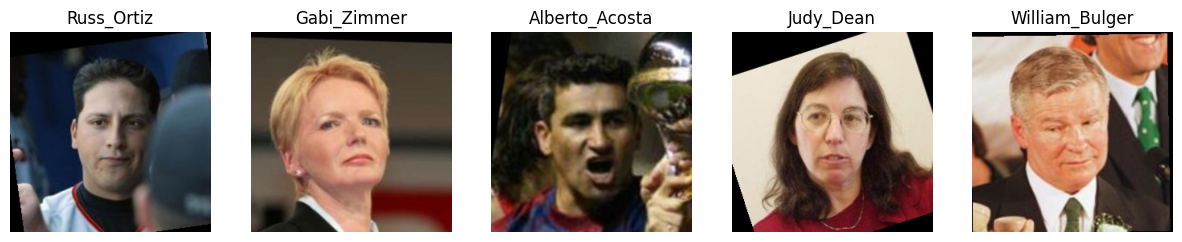

In [12]:
# Load OpenCV's pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# List the directories (each directory corresponds to a person)
lfw_images_dir = os.path.join(extracted_dir, "lfw_funneled")
people_dirs = [d for d in os.listdir(lfw_images_dir) if os.path.isdir(os.path.join(lfw_images_dir, d))]
print(f"Total number of people in the dataset: {len(people_dirs)}")
print("Sample directories:", people_dirs[:5])

# Load a few sample images
sample_images = []
sample_labels = []
sample_paths = []

# Pick the first few people and one image from each
for person in people_dirs[:5]:  # Limit to 5 people for visualization
    person_dir = os.path.join(lfw_images_dir, person)
    images = [f for f in os.listdir(person_dir) if f.endswith(".jpg")]
    if images:
        img_path = os.path.join(person_dir, images[0])  # Take the first image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
        sample_images.append(img)
        sample_labels.append(person)
        sample_paths.append(img_path)

# Display the sample images
plt.figure(figsize=(15, 5))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

25-03-22 15:43:20 - gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:01<00:00, 359MB/s] 


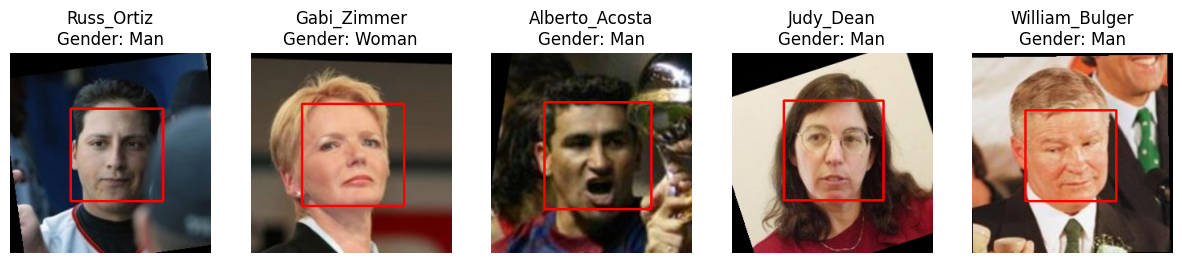

Russ_Ortiz: Predicted Gender - Man
Gabi_Zimmer: Predicted Gender - Woman
Alberto_Acosta: Predicted Gender - Man
Judy_Dean: Predicted Gender - Man
William_Bulger: Predicted Gender - Man


In [13]:
# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Function to predict gender using deepface
def predict_gender(image_path):
    try:
        result = DeepFace.analyze(img_path=image_path, actions=['gender'], enforce_detection=False)
        gender = result[0]['dominant_gender']
        return gender
    except Exception as e:
        print(f"Error predicting gender: {e}")
        return "Unknown"

# Detect faces and predict gender for each sample image
plt.figure(figsize=(15, 5))
for i, (img, label, img_path) in enumerate(zip(sample_images, sample_labels, sample_paths)):
    faces = detect_faces(img)
    img_copy = img.copy()
    
    # Draw rectangles around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    # Predict gender
    gender = predict_gender(img_path)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img_copy)
    plt.title(f"{label}\nGender: {gender}")
    plt.axis("off")
plt.show()

# Print gender predictions
for label, gender in zip(sample_labels, [predict_gender(path) for path in sample_paths]):
    print(f"{label}: Predicted Gender - {gender}")

In [14]:
# Install deepface (if not already installed)
!pip install deepface

# Import libraries
import tarfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from deepface import DeepFace

# Define the dataset path (based on the screenshot)
dataset_path = "/kaggle/input/1fwpeople"
tgz_file = os.path.join(dataset_path, "lfw-funneled.tgz")
extracted_dir = "/kaggle/working/lfw-funneled"

# Create a directory to extract the files (if not already done)
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Extract the .tgz file (if not already extracted)
if not os.path.exists(os.path.join(extracted_dir, "lfw_funneled")):
    print("Extracting the dataset...")
    with tarfile.open(tgz_file, "r:gz") as tar:
        tar.extractall(path=extracted_dir)
    print("Extraction complete!")

In [15]:
# Load OpenCV's pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# List the directories (each directory corresponds to a person)
lfw_images_dir = os.path.join(extracted_dir, "lfw_funneled")
people_dirs = [d for d in os.listdir(lfw_images_dir) if os.path.isdir(os.path.join(lfw_images_dir, d))]
print(f"Total number of people in the dataset: {len(people_dirs)}")
print("Sample directories:", people_dirs[:5])

# Load a few sample images
sample_images = []
sample_labels = []
sample_paths = []

# Pick the first few people and one image from each
for person in people_dirs[:5]:  # Limit to 5 people for visualization
    person_dir = os.path.join(lfw_images_dir, person)
    images = [f for f in os.listdir(person_dir) if f.endswith(".jpg")]
    if images:
        img_path = os.path.join(person_dir, images[0])  # Take the first image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
        sample_images.append(img)
        sample_labels.append(person)
        sample_paths.append(img_path)

Total number of people in the dataset: 5749
Sample directories: ['Russ_Ortiz', 'Gabi_Zimmer', 'Alberto_Acosta', 'Judy_Dean', 'William_Bulger']


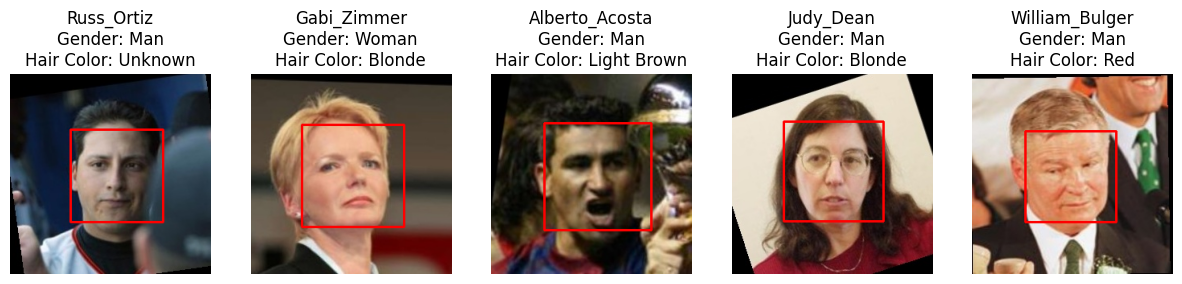


Prediction Summary:
Russ_Ortiz: Gender - Man, Hair Color - Unknown
Gabi_Zimmer: Gender - Woman, Hair Color - Blonde
Alberto_Acosta: Gender - Man, Hair Color - Light Brown
Judy_Dean: Gender - Man, Hair Color - Blonde
William_Bulger: Gender - Man, Hair Color - Red


In [16]:
# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Function to predict gender using deepface
def predict_gender(image_path):
    try:
        result = DeepFace.analyze(img_path=image_path, actions=['gender'], enforce_detection=False)
        gender = result[0]['dominant_gender']
        return gender
    except Exception as e:
        print(f"Error predicting gender: {e}")
        return "Unknown"

# Function to predict hair color
def predict_hair_color(image, face_coords):
    try:
        x, y, w, h = face_coords
        # Define the region above the face (likely where hair is)
        hair_region_y_start = max(0, y - int(h * 0.5))  # Start above the face
        hair_region_y_end = y  # End at the top of the face
        hair_region_x_start = max(0, x - int(w * 0.1))  # Slightly wider than the face
        hair_region_x_end = min(image.shape[1], x + w + int(w * 0.1))
        
        # Extract the hair region
        hair_region = image[hair_region_y_start:hair_region_y_end, hair_region_x_start:hair_region_x_end]
        if hair_region.size == 0:
            return "Unknown"
        
        # Convert to HSV color space for better color analysis
        hair_region_hsv = cv2.cvtColor(hair_region, cv2.COLOR_RGB2HSV)
        
        # Calculate the average color in the region
        avg_color = np.mean(hair_region_hsv, axis=(0, 1))
        hue = avg_color[0]  # Hue channel in HSV
        
        # Map hue to common hair colors (approximate ranges)
        if 0 <= hue < 15 or 165 <= hue <= 180:  # Red hues
            return "Red"
        elif 15 <= hue < 30:  # Orange to light brown
            return "Blonde"
        elif 30 <= hue < 60:  # Yellow to dark blonde/light brown
            return "Light Brown"
        elif 60 <= hue < 120:  # Greenish (unlikely for hair, but could be dyed)
            return "Unknown"
        elif 120 <= hue < 165:  # Blue to purple (unlikely, possibly gray or dyed)
            return "Gray"
        else:
            # If the hue doesn't match, check the value (brightness) for dark colors
            value = avg_color[2]
            if value < 50:  # Very dark
                return "Black"
            else:
                return "Brown"
    except Exception as e:
        print(f"Error predicting hair color: {e}")
        return "Unknown"

# Detect faces, predict gender, and predict hair color for each sample image
plt.figure(figsize=(15, 5))
for i, (img, label, img_path) in enumerate(zip(sample_images, sample_labels, sample_paths)):
    faces = detect_faces(img)
    img_copy = img.copy()
    
    # Draw rectangles around detected faces
    gender = "No face detected"
    hair_color = "No face detected"
    if len(faces) > 0:
        # Take the first detected face
        x, y, w, h = faces[0]
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
        gender = predict_gender(img_path)
        hair_color = predict_hair_color(img, faces[0])
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img_copy)
    plt.title(f"{label}\nGender: {gender}\nHair Color: {hair_color}")
    plt.axis("off")
plt.show()

# Print predictions
print("\nPrediction Summary:")
for label, img, img_path in zip(sample_labels, sample_images, sample_paths):
    faces = detect_faces(img)
    if len(faces) > 0:
        gender = predict_gender(img_path)
        hair_color = predict_hair_color(img, faces[0])
        print(f"{label}: Gender - {gender}, Hair Color - {hair_color}")
    else:
        print(f"{label}: No face detected")

In [17]:
# Install required libraries
!pip install deepface mediapipe scikit-learn

# Import libraries
import tarfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from deepface import DeepFace
import mediapipe as mp
from sklearn.cluster import KMeans

# Define the dataset path (based on the screenshot)
dataset_path = "/kaggle/input/1fwpeople"
tgz_file = os.path.join(dataset_path, "lfw-funneled.tgz")
extracted_dir = "/kaggle/working/lfw-funneled"

# Create a directory to extract the files (if not already done)
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Extract the .tgz file (if not already extracted)
if not os.path.exists(os.path.join(extracted_dir, "lfw_funneled")):
    print("Extracting the dataset...")
    with tarfile.open(tgz_file, "r:gz") as tar:
        tar.extractall(path=extracted_dir)
    print("Extraction complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [18]:
# Load OpenCV's pre-trained Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# List the directories (each directory corresponds to a person)
lfw_images_dir = os.path.join(extracted_dir, "lfw_funneled")
people_dirs = [d for d in os.listdir(lfw_images_dir) if os.path.isdir(os.path.join(lfw_images_dir, d))]
print(f"Total number of people in the dataset: {len(people_dirs)}")
print("Sample directories:", people_dirs[:5])

# Load a few sample images
sample_images = []
sample_labels = []
sample_paths = []

# Pick the first few people and one image from each
for person in people_dirs[:5]:  # Limit to 5 people for visualization
    person_dir = os.path.join(lfw_images_dir, person)
    images = [f for f in os.listdir(person_dir) if f.endswith(".jpg")]
    if images:
        img_path = os.path.join(person_dir, images[0])  # Take the first image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
        sample_images.append(img)
        sample_labels.append(person)
        sample_paths.append(img_path)

Total number of people in the dataset: 5749
Sample directories: ['Russ_Ortiz', 'Gabi_Zimmer', 'Alberto_Acosta', 'Judy_Dean', 'William_Bulger']


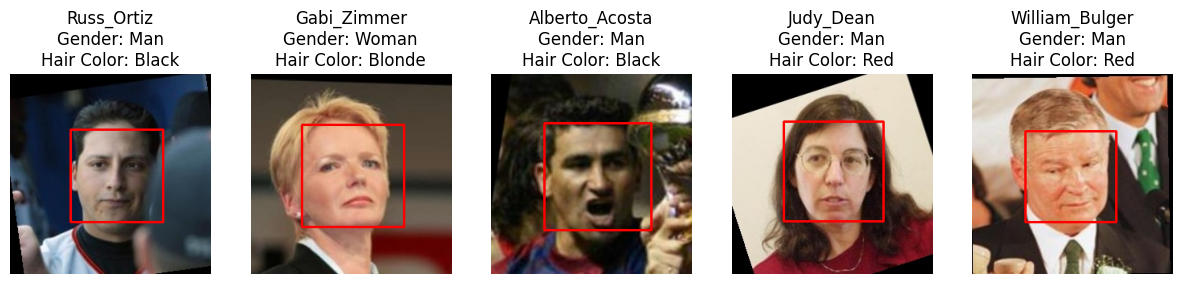


Prediction Summary:
Russ_Ortiz: Gender - Man, Hair Color - Black
Gabi_Zimmer: Gender - Woman, Hair Color - Blonde
Alberto_Acosta: Gender - Man, Hair Color - Black
Judy_Dean: Gender - Man, Hair Color - Red
William_Bulger: Gender - Man, Hair Color - Red


In [19]:
# Initialize MediaPipe Hair Segmentation
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Function to predict gender using deepface
def predict_gender(image_path):
    try:
        result = DeepFace.analyze(img_path=image_path, actions=['gender'], enforce_detection=False)
        gender = result[0]['dominant_gender']
        return gender
    except Exception as e:
        print(f"Error predicting gender: {e}")
        return "Unknown"

# Function to segment hair using MediaPipe
def segment_hair(image):
    # Convert image to RGB (MediaPipe expects RGB)
    image_rgb = image.copy()
    # Resize image for faster processing
    image_rgb = cv2.resize(image_rgb, (256, 256))
    height, width = image_rgb.shape[:2]
    
    # Process the image with MediaPipe
    results = selfie_segmentation.process(image_rgb)
    # Get the segmentation mask (0 for background, 1 for person)
    mask = results.segmentation_mask
    
    # Threshold the mask to create a binary mask (1 for person, 0 for background)
    condition = mask > 0.5
    hair_mask = np.zeros((height, width), dtype=np.uint8)
    hair_mask[condition] = 255
    
    # Resize the mask back to the original image size
    hair_mask = cv2.resize(hair_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    return hair_mask

# Function to predict hair color using clustering
def predict_hair_color(image, hair_mask, face_coords):
    try:
        x, y, w, h = face_coords
        # Focus on the upper part of the image (above the face) to avoid skin
        hair_region_y_start = max(0, y - int(h * 0.5))
        hair_region_y_end = y
        hair_region_x_start = max(0, x - int(w * 0.1))
        hair_region_x_end = min(image.shape[1], x + w + int(w * 0.1))
        
        # Extract the hair region using the mask
        hair_region = image[hair_region_y_start:hair_region_y_end, hair_region_x_start:hair_region_x_end]
        hair_mask_region = hair_mask[hair_region_y_start:hair_region_y_end, hair_region_x_start:hair_region_x_end]
        
        # Get the pixels that belong to the hair (where mask is 255)
        hair_pixels = hair_region[hair_mask_region == 255]
        if len(hair_pixels) < 100:  # Not enough hair pixels
            return "Unknown"
        
        # Apply K-Means clustering to find the dominant color
        hair_pixels = hair_pixels.reshape(-1, 3)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(hair_pixels)
        dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
        
        # Convert the dominant color to HSV for better color classification
        dominant_color = dominant_color.reshape(1, 1, 3).astype(np.uint8)
        dominant_color_hsv = cv2.cvtColor(dominant_color, cv2.COLOR_RGB2HSV)
        hue, saturation, value = dominant_color_hsv[0, 0]
        
        # Map the color to common hair colors
        if value < 40:  # Very dark
            return "Black"
        elif 0 <= hue < 15 or 165 <= hue <= 180:  # Red hues
            return "Red"
        elif 15 <= hue < 30:  # Orange to light brown
            return "Blonde"
        elif 30 <= hue < 60:  # Yellow to dark blonde/light brown
            return "Light Brown"
        elif 120 <= hue < 165:  # Blue to purple (possibly gray or dyed)
            return "Gray"
        else:
            return "Brown"
    except Exception as e:
        print(f"Error predicting hair color: {e}")
        return "Unknown"

# Detect faces, predict gender, and predict hair color for each sample image
plt.figure(figsize=(15, 5))
for i, (img, label, img_path) in enumerate(zip(sample_images, sample_labels, sample_paths)):
    faces = detect_faces(img)
    img_copy = img.copy()
    
    # Draw rectangles around detected faces
    gender = "No face detected"
    hair_color = "No face detected"
    if len(faces) > 0:
        # Take the first detected face
        x, y, w, h = faces[0]
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)
        gender = predict_gender(img_path)
        # Segment hair
        hair_mask = segment_hair(img)
        hair_color = predict_hair_color(img, hair_mask, faces[0])
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img_copy)
    plt.title(f"{label}\nGender: {gender}\nHair Color: {hair_color}")
    plt.axis("off")
plt.show()

# Print predictions
print("\nPrediction Summary:")
for label, img, img_path in zip(sample_labels, sample_images, sample_paths):
    faces = detect_faces(img)
    if len(faces) > 0:
        gender = predict_gender(img_path)
        hair_mask = segment_hair(img)
        hair_color = predict_hair_color(img, hair_mask, faces[0])
        print(f"{label}: Gender - {gender}, Hair Color - {hair_color}")
    else:
        print(f"{label}: No face detected")